In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import uproot as up
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc
from sklearn.datasets import dump_svmlight_file
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from scipy.stats import uniform, randint

from tqdm import tqdm
import os
import time

In [2]:
# Find the filepaths for the root files
sig = "/data/dajiang/2HDM/ML/samples/signal/Low/"
sig_files = os.listdir(sig)
sig_root_files = [os.path.join(sig,file) for file in sig_files if file.endswith(".root")]

# Make a list of all signal file paths
sig_paths = []
for i in range(len(sig_root_files)):
    sig_paths.append(sig_root_files[i])

# TTbar filepaths
ttbar_paths = "/data/dajiang/2HDM/ML/samples/ttbar/training/user.rjoshi.38019065._000005.output.root"

In [3]:
# Signal Data
start_time = time.time()

# Create dataframe for total signal
sig_df = pd.DataFrame([])

# Add each signal file data to the total signal dataframe
sig_counter = 0
for path in sig_paths:
    sig_counter += 1
    print("File {} of {}: {}".format(sig_counter,len(sig_paths),path)) 

    reco_tree = up.open(path)["reco"]
    reco_arrays = reco_tree.arrays(library = "np")
    reco_df = pd.DataFrame(reco_arrays)
    temp_df = reco_df[(reco_df['nBjets_NOSYS'] > 1) & (reco_df['nBjets_NOSYS'] + reco_df['nLjets_NOSYS'] > 3)] # preselection cuts
    sig_df = pd.concat([sig_df, temp_df]).sample(frac=1).reset_index(drop=True)
    
# ID for signal events
sig_df["Class"] = np.ones(len(sig_df["bjet1_pt_NOSYS"]),dtype=int) # truth label: signal = 1

print()
print("Total number of signal events: {}".format(len(sig_df["bjet1_pt_NOSYS"])))

elapsed_time = time.time() - start_time
print()
print("Time elapsed: {} seconds".format(elapsed_time))

File 1 of 6: /data/dajiang/2HDM/ML/samples/signal/Low/400_250_mc20a.root
File 2 of 6: /data/dajiang/2HDM/ML/samples/signal/Low/400_300_mc20a.root
File 3 of 6: /data/dajiang/2HDM/ML/samples/signal/Low/400_250_mc20d.root
File 4 of 6: /data/dajiang/2HDM/ML/samples/signal/Low/400_200_mc20a.root
File 5 of 6: /data/dajiang/2HDM/ML/samples/signal/Low/400_300_mc20d.root
File 6 of 6: /data/dajiang/2HDM/ML/samples/signal/Low/400_200_mc20d.root

Total number of signal events: 24410

Time elapsed: 46.38861966133118 seconds


In [4]:
# Load TTBAR data
start_time = time.time()

reco_tree = up.open(ttbar_paths)["reco"]
reco_arrays = reco_tree.arrays(library = "np")
reco_df = pd.DataFrame(reco_arrays)
ttbar_df = reco_df[(reco_df['nBjets_NOSYS'] > 1) & (reco_df['nBjets_NOSYS'] + reco_df['nLjets_NOSYS'] > 3)][:25000] # preselection cuts

# ID for ttbar events
ttbar_df["Class"] = np.zeros(len(ttbar_df["bjet1_pt_NOSYS"]),dtype=int) # truth label: ttbar = 0

print()
print("Total ttbar events: {}".format(len(ttbar_df)))
      
elapsed_time = time.time() - start_time
print()
print("Time elapsed: {} seconds".format(elapsed_time))


Total ttbar events: 25000

Time elapsed: 982.8566777706146 seconds


In [24]:
start_time = time.time()

# Define vectorized deltaR function
def deltaR(eta1, phi1, eta2, phi2):
    d_eta = eta1 - eta2
    d_phi = (phi1 - phi2 + np.pi) % (2 * np.pi) - np.pi
    return np.sqrt(d_eta**2 + d_phi**2)

# Define function to calculate delta R between two objects
def calculate_deltaR(df, object1_prefix, object2_prefix):
    # Create new column name
    col_name = f'deltaR_{object1_prefix}_{object2_prefix}'
    
    # Select the appropriate columns for eta and phi
    eta1 = df.get(f'{object1_prefix}_eta_NOSYS', df.get(f'{object1_prefix}_eta_fitted_NOSYS', np.nan))
    phi1 = df.get(f'{object1_prefix}_phi_NOSYS', df.get(f'{object1_prefix}_phi_fitted_NOSYS', np.nan))
    eta2 = df.get(f'{object2_prefix}_eta_NOSYS', df.get(f'{object2_prefix}_eta_fitted_NOSYS', np.nan))
    phi2 = df.get(f'{object2_prefix}_phi_NOSYS', df.get(f'{object2_prefix}_phi_fitted_NOSYS', np.nan))
    
    # Handle invalid entries (set delta R to NaN for invalid inputs)
    mask = (eta1 == -999) | (eta2 == -999) | (phi1 == -999) | (phi2 == -999)
    delta_r = deltaR(eta1, phi1, eta2, phi2)
    delta_r[mask] = np.nan
    
    # Assign the computed delta R to the new column
    df[col_name] = delta_r

# Define combinations for sig_df and ttbar_df: 78 total
combinations = [
    ('A', 'Hp'), ('A', 'top'), ('A', 'WfromTop'), ('A', 'WfromH'), ('A', 'Wb_nonTop'),
    ('Hp', 'top'), ('Hp', 'WfromTop'), ('Hp', 'WfromH'), ('Hp', 'Wb_nonTop'),
    ('top', 'WfromTop'), ('top', 'WfromH'), ('top', 'Wb_nonTop'),
    ('WfromTop', 'WfromH'), ('WfromTop', 'Wb_nonTop'),
    ('WfromH', 'Wb_nonTop'),
    ('bjet1', 'bjet2'), ('ljet1', 'ljet2'), ('bjet1', 'ljet1'), ('bjet1', 'ljet2'),
    ('bjet2', 'ljet1'), ('bjet2', 'ljet2'), ('bjet1', 'ljet3'), ('bjet1', 'ljet4'),
    ('bjet2', 'ljet3'), ('bjet2', 'ljet4'), ('ljet1', 'ljet3'), ('ljet1', 'ljet4'),
    ('ljet2', 'ljet3'), ('ljet2', 'ljet4'), ('ljet3', 'ljet4'),
    ('bjet1', 'lepton'), ('bjet2', 'lepton'), ('ljet1', 'lepton'),
    ('ljet2', 'lepton'), ('ljet3', 'lepton'), ('ljet4', 'lepton'),
    ('A', 'bjet1'), ('A', 'bjet2'), ('A', 'ljet1'), ('A', 'ljet2'),
    ('A', 'ljet3'), ('A', 'ljet4'), ('A', 'lepton'),
    ('top', 'bjet1'), ('top', 'bjet2'), ('top', 'ljet1'), ('top', 'ljet2'),
    ('top', 'ljet3'), ('top', 'ljet4'), ('top', 'lepton'),
    ('WfromTop', 'bjet1'), ('WfromTop', 'bjet2'), ('WfromTop', 'ljet1'), ('WfromTop', 'ljet2'),
    ('WfromTop', 'ljet3'), ('WfromTop', 'ljet4'),('WfromTop', 'lepton'), 
    ('Wb_nonTop', 'bjet1'), ('Wb_nonTop', 'bjet2'), ('Wb_nonTop', 'ljet1'), ('Wb_nonTop', 'ljet2'),
    ('Wb_nonTop', 'ljet3'), ('Wb_nonTop', 'ljet4'), ('Wb_nonTop', 'lepton'),
    ('Hp', 'bjet1'), ('Hp', 'bjet2'), ('Hp', 'ljet1'), ('Hp', 'ljet2'),
    ('Hp', 'ljet3'), ('Hp', 'ljet4'), ('Hp', 'lepton'),
    ('WfromH', 'bjet1'), ('WfromH', 'bjet2'), ('WfromH', 'ljet1'), ('WfromH', 'ljet2'),
    ('WfromH', 'ljet3'), ('WfromH', 'ljet4'), ('WfromH', 'lepton'),
]

# Calculate delta Rs
for comb in tqdm(combinations):
    calculate_deltaR(ttbar_df, comb[0], comb[1])
    calculate_deltaR(sig_df, comb[0], comb[1])

elapsed_time = time.time() - start_time
print()
print("Time elapsed: {} seconds".format(elapsed_time))

100%|██████████| 78/78 [00:00<00:00, 204.66it/s]


Time elapsed: 0.38358283042907715 seconds


In [25]:
# Combine signal and ttbar, then shuffle
start_time = time.time()

df = pd.concat([ttbar_df, sig_df]).sample(frac=1).reset_index(drop=True)

elapsed_time = time.time() - start_time
print()
print("Time elapsed: {} seconds".format(elapsed_time))


Time elapsed: 0.49628400802612305 seconds


In [26]:
# Truth labels
y_df = df.pop('Class')

In [27]:
branch_names = ['bjet1_pt_NOSYS', 'bjet1_mass_NOSYS', 
                'bjet2_pt_NOSYS', 'bjet2_mass_NOSYS', 
                'ljet1_pt_NOSYS', 'ljet1_mass_NOSYS',
                'ljet2_pt_NOSYS', 'ljet2_mass_NOSYS',
                #'ljet3_pt_NOSYS', 'ljet3_mass_NOSYS',
                #'ljet4_pt_NOSYS',  'ljet4_mass_NOSYS',
                'lepton_pt_NOSYS',  'lepton_mass_NOSYS',
                'A_pt_fitted_NOSYS', 'A_mass_fitted_NOSYS',
                'Hp_pt_fitted_NOSYS',  'Hp_mass_fitted_NOSYS',
                'top_pt_fitted_NOSYS', 'top_mass_fitted_NOSYS',
                'WfromTop_pt_fitted_NOSYS', 'WfromTop_mass_fitted_NOSYS',
                'WfromH_pt_fitted_NOSYS', 'WfromH_mass_fitted_NOSYS',
                'Wb_nonTop_pt_fitted_NOSYS',  'Wb_nonTop_mass_fitted_NOSYS',
                'MET_phi_NOSYS', 'MET_NOSYS',
                'cos_theta_star_lep_Wlep_NOSYS',
                'cos_theta_star_Hp_A_NOSYS',
                 'cos_theta_star_Whad_ljet1_NOSYS',
                 'cos_theta_star_Hp_top_NOSYS',
                 'cos_theta_star_A_top_NOSYS',
#                 'nBjets_NOSYS',
#                 'nLjets_NOSYS',            
    'deltaR_bjet1_bjet2',
    'deltaR_bjet1_ljet1',
    'deltaR_bjet1_ljet2',
    #'deltaR_bjet1_ljet3',
    #'deltaR_bjet1_ljet4',
    'deltaR_bjet1_lepton',
    'deltaR_bjet2_ljet1',
    'deltaR_bjet2_ljet2',
    #'deltaR_bjet2_ljet3',
    #'deltaR_bjet2_ljet4',
    'deltaR_bjet2_lepton',
    'deltaR_ljet1_ljet2',
    #'deltaR_ljet1_ljet3',
    #'deltaR_ljet1_ljet4',
    'deltaR_ljet1_lepton',
    #'deltaR_ljet2_ljet3',
    #'deltaR_ljet2_ljet4',
    'deltaR_ljet2_lepton',
    #'deltaR_ljet3_ljet4',
    #'deltaR_ljet3_lepton',
    #'deltaR_ljet4_lepton',
    'deltaR_A_Hp',
    'deltaR_A_top',
    'deltaR_A_WfromTop',
    'deltaR_A_WfromH',
    'deltaR_A_Wb_nonTop',
    'deltaR_A_bjet1',
    'deltaR_A_bjet2',
    'deltaR_A_ljet1',
    'deltaR_A_ljet2',
    #'deltaR_A_ljet3',
    #'deltaR_A_ljet4',
    'deltaR_A_lepton',
    'deltaR_Hp_bjet1',
    'deltaR_Hp_bjet2',
    'deltaR_Hp_ljet1',
    'deltaR_Hp_ljet2',
    #'deltaR_Hp_ljet3',
    #'deltaR_Hp_ljet4',
    'deltaR_Hp_lepton',
    'deltaR_top_bjet1',
    'deltaR_top_bjet2',
    'deltaR_top_ljet1',
    'deltaR_top_ljet2',
    #'deltaR_top_ljet3',
    #'deltaR_top_ljet4',
    'deltaR_top_lepton',
    'deltaR_WfromTop_bjet1',
    'deltaR_WfromTop_bjet2',
    'deltaR_WfromTop_ljet1',
    'deltaR_WfromTop_ljet2',
    #'deltaR_WfromTop_ljet3',
    #'deltaR_WfromTop_ljet4',
    'deltaR_WfromTop_lepton',
    'deltaR_WfromH_bjet1',
    'deltaR_WfromH_bjet2',
    'deltaR_WfromH_ljet1',
    'deltaR_WfromH_ljet2',
    #'deltaR_WfromH_ljet3',
    #'deltaR_WfromH_ljet4',
    'deltaR_WfromH_lepton',
    'deltaR_Wb_nonTop_bjet1',
    'deltaR_Wb_nonTop_bjet2',
    'deltaR_Wb_nonTop_ljet1',
    'deltaR_Wb_nonTop_ljet2',
    #'deltaR_Wb_nonTop_ljet3',
    #'deltaR_Wb_nonTop_ljet4',
    'deltaR_Wb_nonTop_lepton',
    'deltaR_Hp_top',
    'deltaR_Hp_WfromTop',
    'deltaR_Hp_WfromH',
    'deltaR_Hp_Wb_nonTop',
    'deltaR_top_WfromTop',
    'deltaR_top_WfromH',
    'deltaR_top_Wb_nonTop',
    'deltaR_WfromTop_WfromH',
    'deltaR_WfromTop_Wb_nonTop',
    'deltaR_WfromH_Wb_nonTop'
]

In [28]:
X_train,X_test,y_train,y_test = train_test_split(df[branch_names],y_df,test_size=0.2,random_state=0)

In [29]:
##applying weights for unbalanced samples
def CreateBalancedSampleWeights(y_train, largest_class_weight_coef):
    classes = np.unique(y_train, axis=0)
    classes.sort()
    class_samples = np.bincount(y_train)
    total_samples = class_samples.sum()
    n_classes = len(class_samples)
    weights = total_samples / (n_classes * class_samples * 1.0)
    class_weight_dict = {key: value for (key, value) in zip(classes, weights)}
    class_weight_dict[classes[1]] = class_weight_dict[classes[1]] * largest_class_weight_coef
    sample_weights = [class_weight_dict[y] for y in y_train]
    return sample_weights

In [30]:
largest_class_weight_coef = max(y_df.value_counts().values) / df.shape[0]
weight = CreateBalancedSampleWeights(y_train, largest_class_weight_coef)

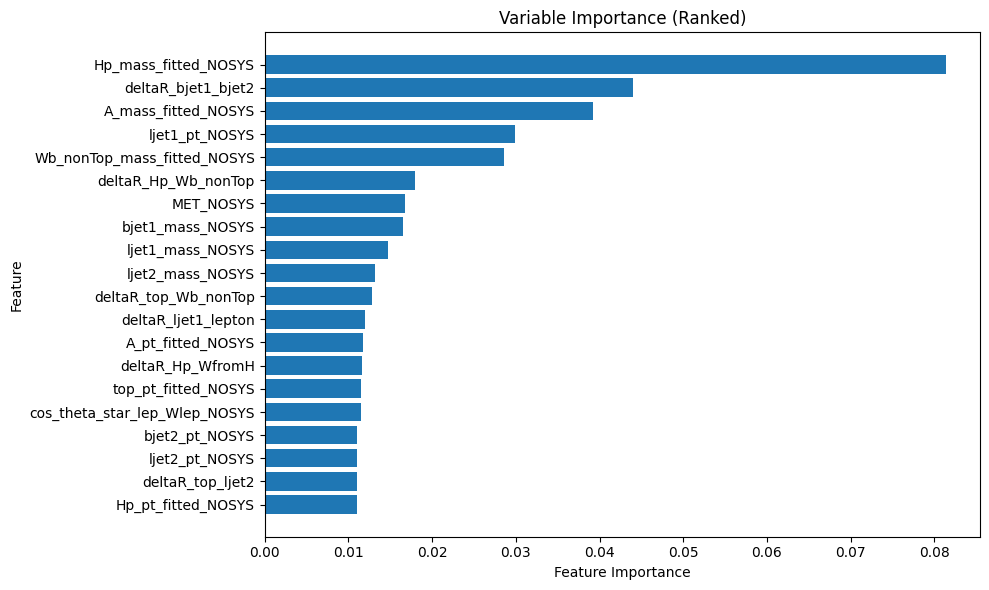

Rank 1: Feature: cos_theta_star_A_top_NOSYS, Importance Score: 0.0074179465882480145
Rank 2: Feature: deltaR_top_bjet2, Importance Score: 0.007682181894779205
Rank 3: Feature: deltaR_Wb_nonTop_ljet1, Importance Score: 0.007712794933468103
Rank 4: Feature: deltaR_A_top, Importance Score: 0.007785873021930456
Rank 5: Feature: lepton_mass_NOSYS, Importance Score: 0.007794598583132029
Rank 6: Feature: deltaR_A_bjet2, Importance Score: 0.007842928171157837
Rank 7: Feature: deltaR_WfromTop_Wb_nonTop, Importance Score: 0.007852026261389256
Rank 8: Feature: deltaR_A_lepton, Importance Score: 0.00791972130537033
Rank 9: Feature: deltaR_Wb_nonTop_bjet1, Importance Score: 0.008019569329917431
Rank 10: Feature: deltaR_A_Hp, Importance Score: 0.00810518953949213
Rank 11: Feature: deltaR_Wb_nonTop_lepton, Importance Score: 0.008121268823742867
Rank 12: Feature: deltaR_Wb_nonTop_ljet2, Importance Score: 0.008227305486798286
Rank 13: Feature: deltaR_Hp_ljet2, Importance Score: 0.008249219506978989
Ran

In [31]:
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)

importance = clf.feature_importances_

sorted_indices = sorted(range(len(importance)), key=lambda i: importance[i])
sorted_branch_names = [branch_names[i] for i in sorted_indices]
sorted_importance = [importance[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.barh(range(20), sorted_importance[-20:], tick_label=sorted_branch_names[-20:])

plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Variable Importance (Ranked)')
plt.tight_layout()  # Adjust layout to prevent clipping of tick labels
plt.savefig("xgboost_plots/features_xgboost_low.png",dpi=200)
plt.show()

for i, (name, score) in enumerate(zip(sorted_branch_names, sorted_importance), 1):
    print(f"Rank {i}: Feature: {name}, Importance Score: {score}")


In [32]:
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
cm

array([[3193, 1825],
       [1433, 3431]])

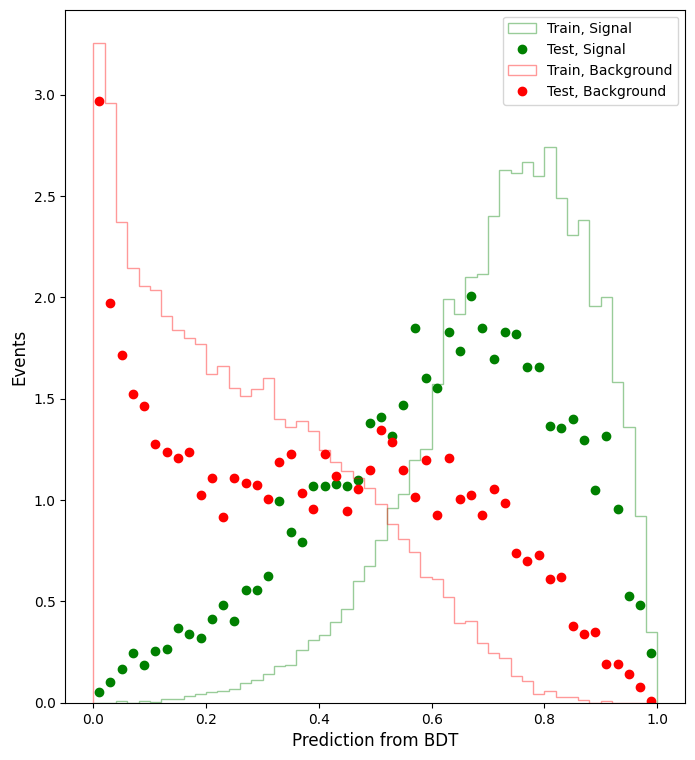

In [33]:
y_pred_phi_train = clf.predict_proba(X_train[y_train==1])
y_pred_phi_test = clf.predict_proba(X_test[y_test==1])
y_pred_tt_train = clf.predict_proba(X_train[y_train==0])
y_pred_tt_test = clf.predict_proba(X_test[y_test==0])


n_bins=50
hist_range=(0,1.0)
plt.figure(figsize=(8,9))

plt.hist(y_pred_phi_train[:,1], bins=n_bins, range=hist_range, histtype='step', color="green", density=True, alpha=0.4, label="Train, Signal")
counts, bin_edges = np.histogram(y_pred_phi_test[:,1], bins=n_bins, range=hist_range, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers, counts, marker="o", linestyle="None", color="green", label="Test, Signal")

plt.hist(y_pred_tt_train[:,1], bins=n_bins, range=hist_range, histtype='step', density=True, alpha=0.4, color="red", label="Train, Background")
counts, bin_edges = np.histogram(y_pred_tt_test[:,1], bins=n_bins, range=hist_range, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers, counts, marker="o", linestyle="None", color="red", label="Test, Background")

plt.xlabel("Prediction from BDT", fontsize=12)
plt.ylabel("Events", fontsize=12)
plt.legend()
plt.savefig("bdt_score_lowh.png",dpi=300)
plt.show()

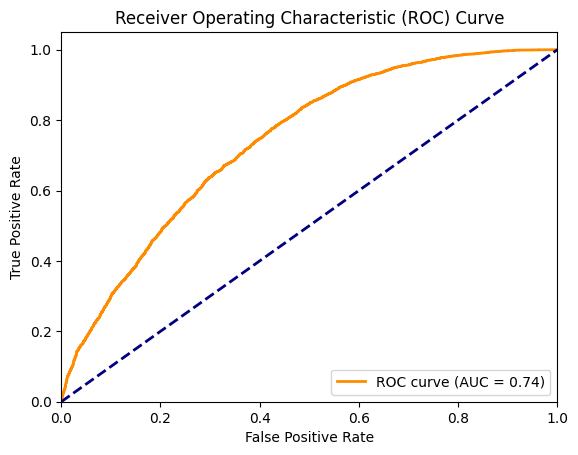

In [34]:
from sklearn.metrics import roc_curve, auc
y_prob = clf.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("roc_xgboost_low.png",dpi=300)
plt.show()

In [35]:
top20 = sorted_branch_names[-20:]
top20

['Hp_pt_fitted_NOSYS',
 'deltaR_top_ljet2',
 'ljet2_pt_NOSYS',
 'bjet2_pt_NOSYS',
 'cos_theta_star_lep_Wlep_NOSYS',
 'top_pt_fitted_NOSYS',
 'deltaR_Hp_WfromH',
 'A_pt_fitted_NOSYS',
 'deltaR_ljet1_lepton',
 'deltaR_top_Wb_nonTop',
 'ljet2_mass_NOSYS',
 'ljet1_mass_NOSYS',
 'bjet1_mass_NOSYS',
 'MET_NOSYS',
 'deltaR_Hp_Wb_nonTop',
 'Wb_nonTop_mass_fitted_NOSYS',
 'ljet1_pt_NOSYS',
 'A_mass_fitted_NOSYS',
 'deltaR_bjet1_bjet2',
 'Hp_mass_fitted_NOSYS']

In [36]:
def plotter(branch,bins):
    fig, ax = plt.subplots()
    # Calculate Number of Overflow and Underflow
    counts_sig, edges_sig = np.histogram(sig_df[branch], bins=bins)
    underflow_count_sig = np.sum(sig_df[branch] < bins[0])
    overflow_count_sig = np.sum(sig_df[branch] >= bins[-1])
    counts_ttbar, edges_ttbar = np.histogram(ttbar_df[branch], bins=bins)
    underflow_count_ttbar = np.sum(ttbar_df[branch] < bins[0])
    overflow_count_ttbar = np.sum(ttbar_df[branch] >= bins[-1])
    # Normalize
    total_count_sig = len(sig_df[branch])
    counts_norm_sig = counts_sig / total_count_sig
    underflow_norm_sig = underflow_count_sig / total_count_sig
    overflow_norm_sig = overflow_count_sig / total_count_sig
    total_count_ttbar = len(ttbar_df[branch])
    counts_norm_ttbar = counts_ttbar / total_count_ttbar
    underflow_norm_ttbar = underflow_count_ttbar / total_count_ttbar
    overflow_norm_ttbar = overflow_count_ttbar / total_count_ttbar
    # Combine into 1 array for heights, and edges
    counts_all_sig = np.concatenate(([underflow_norm_sig], counts_norm_sig, [overflow_norm_sig]))
    edges_all_sig = np.concatenate(([bins[0] - (bins[1] - bins[0])], bins))
    counts_all_ttbar = np.concatenate(([underflow_norm_ttbar], counts_norm_ttbar, [overflow_norm_ttbar]))
    edges_all_ttbar = np.concatenate(([bins[0] - (bins[1] - bins[0])], bins))
    # Plot
    ax.step(edges_all_sig, counts_all_sig, color='green',lw=1,label="signal")
    ax.step(edges_all_ttbar, counts_all_ttbar, color='red',lw=1,label="ttbar")
    ax.legend()
    ax.set_title(branch)
    file_name = os.path.join("xgboost_plots/Low/" + branch + ".png")
    fig.savefig(file_name, dpi=300)

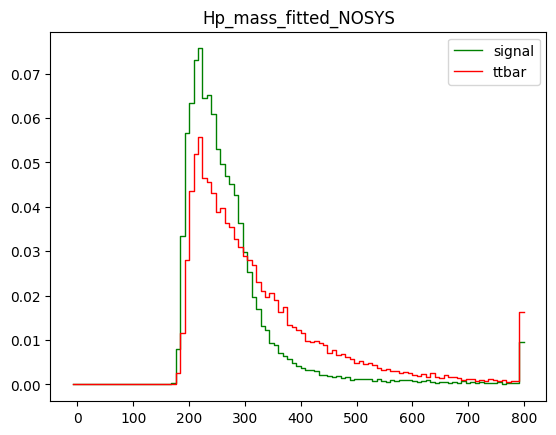

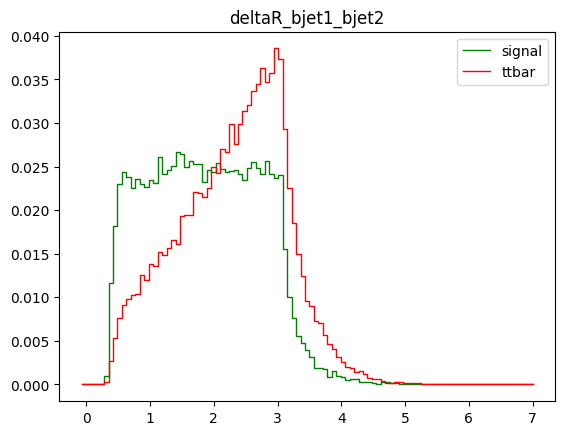

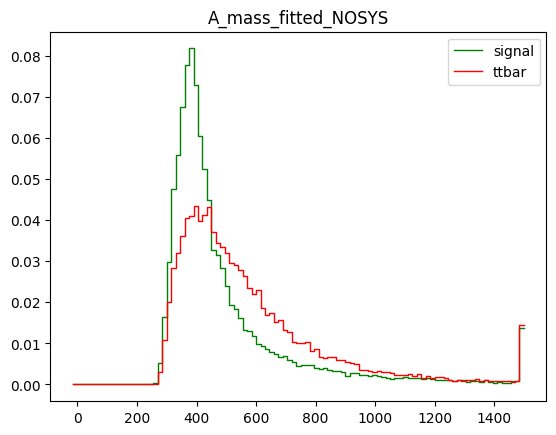

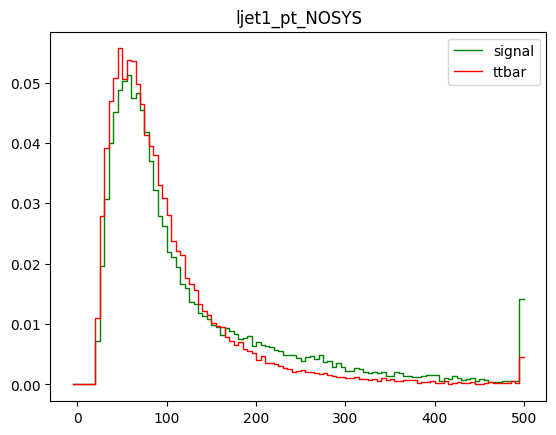

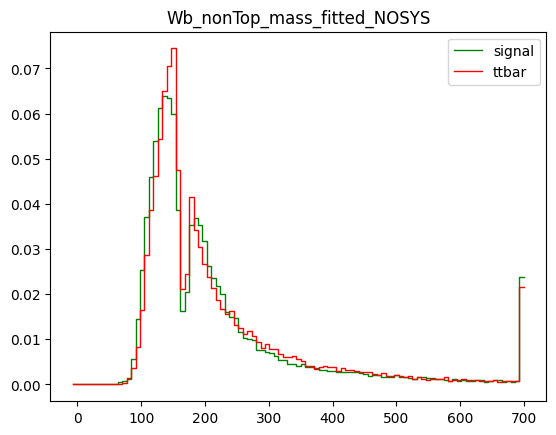

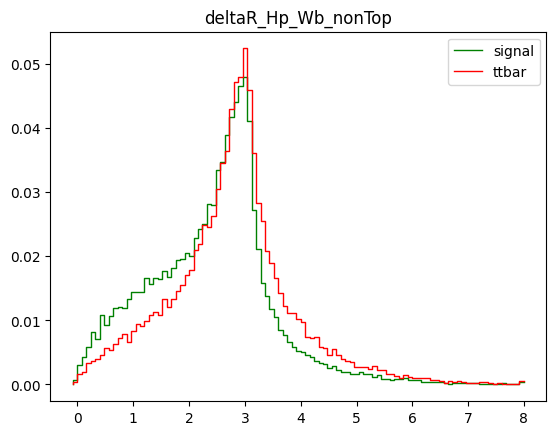

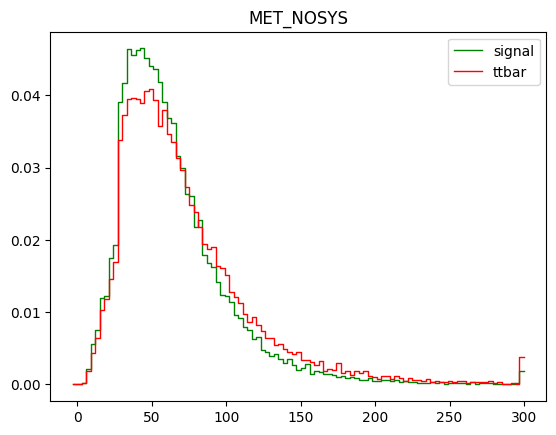

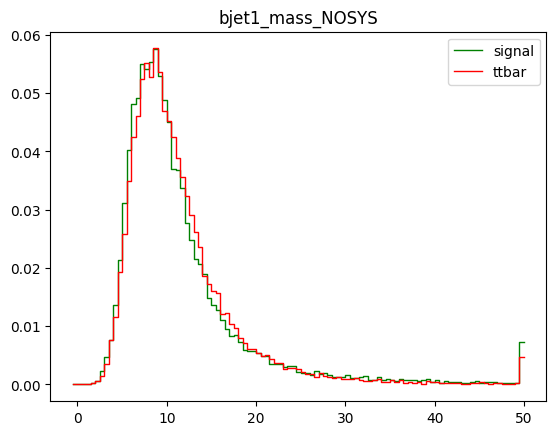

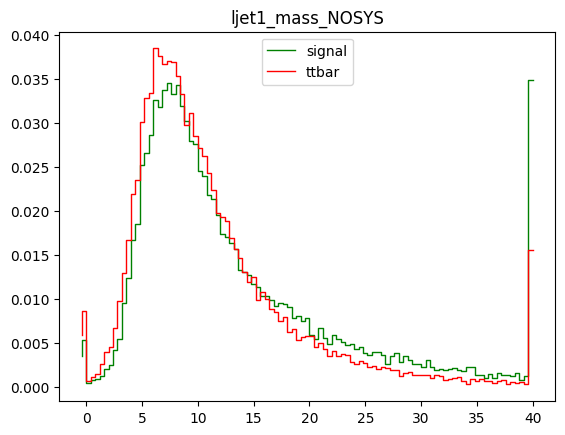

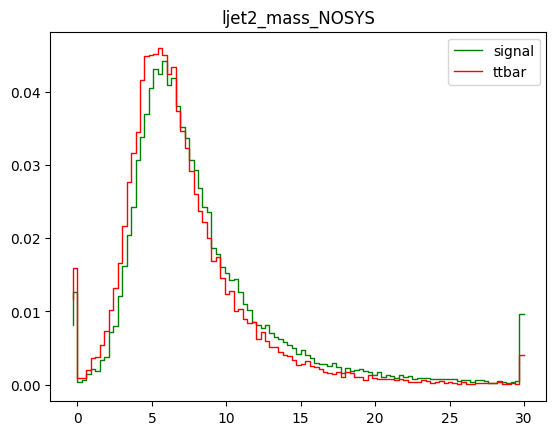

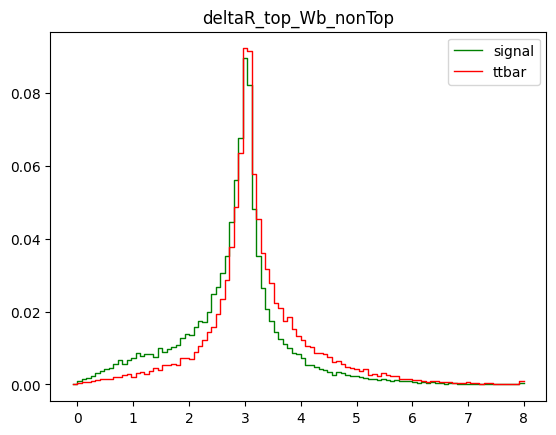

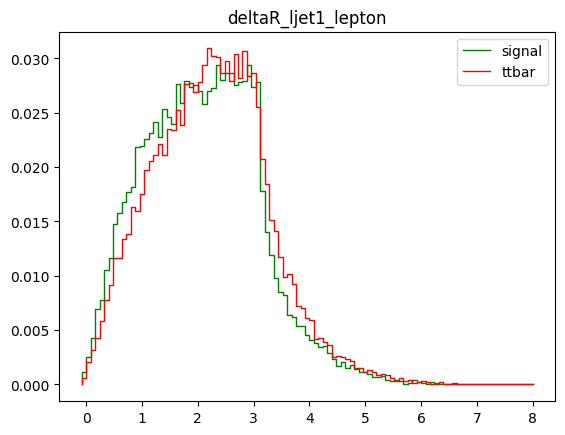

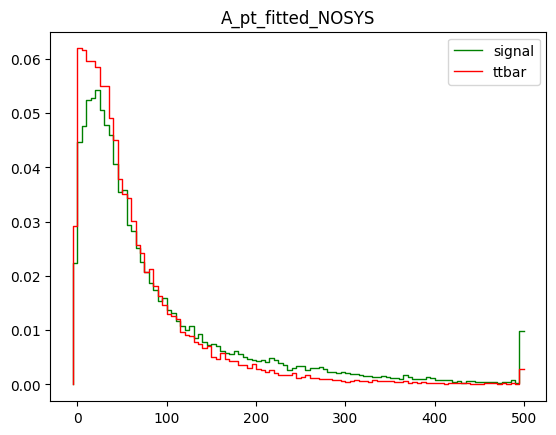

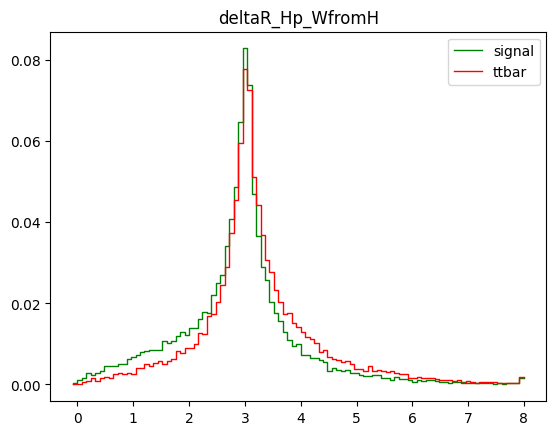

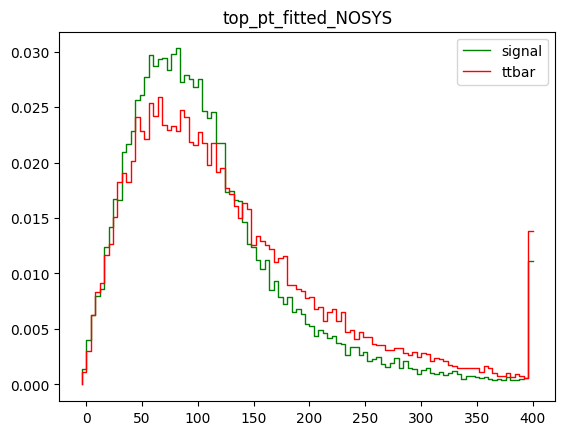

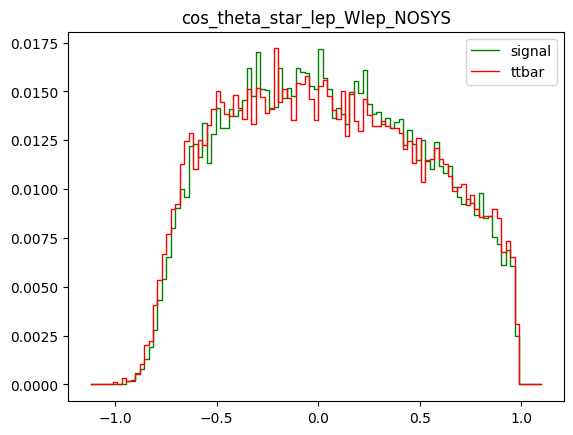

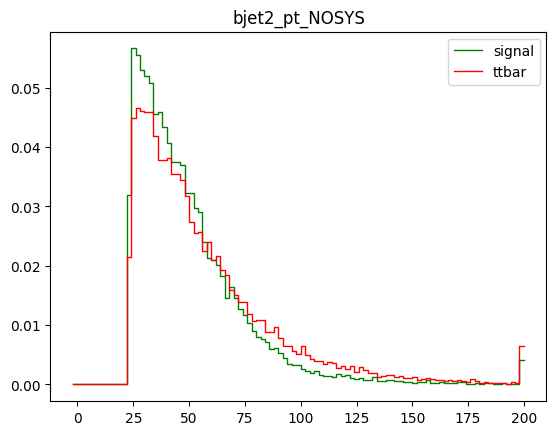

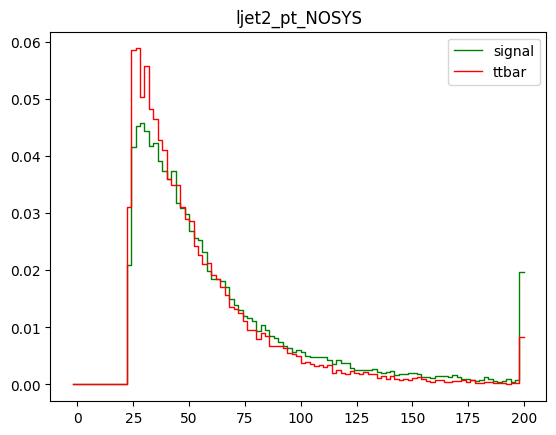

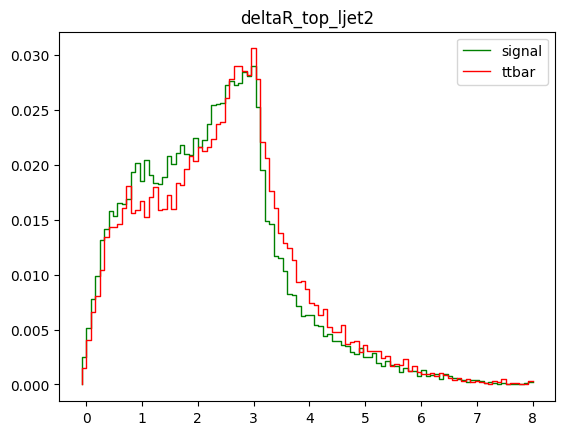

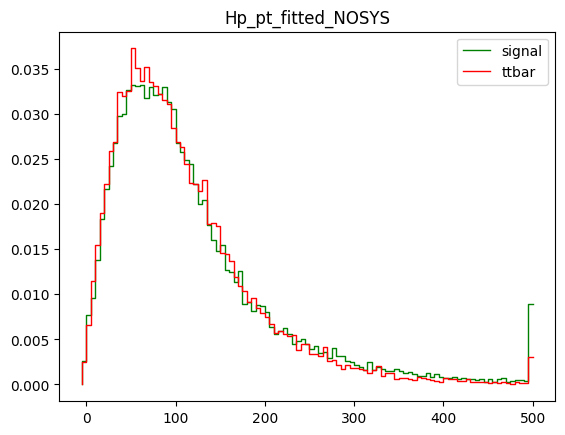

In [42]:
# Plot all 20 features

# 1
bins=np.linspace(0,800,101)
branch = 'Hp_mass_fitted_NOSYS'
plotter(branch,bins)

# 2
bins=np.linspace(0,7,101)
branch = 'deltaR_bjet1_bjet2'
plotter(branch,bins)

# 3
bins=np.linspace(0,1500,101)
branch = 'A_mass_fitted_NOSYS'
plotter(branch,bins)

# 4
bins=np.linspace(0,500,101)
branch = 'ljet1_pt_NOSYS'
plotter(branch,bins)

# 5
bins=np.linspace(0,700,101)
branch = 'Wb_nonTop_mass_fitted_NOSYS'
plotter(branch,bins)

# 6
bins=np.linspace(0,8,101)
branch = 'deltaR_Hp_Wb_nonTop'
plotter(branch,bins)

# 7
bins=np.linspace(0,300,101)
branch = 'MET_NOSYS'
plotter(branch,bins)

# 8
bins=np.linspace(0,50,101)
branch = 'bjet1_mass_NOSYS'
plotter(branch,bins)

# 9
bins=np.linspace(0,40,101)
branch = 'ljet1_mass_NOSYS'
plotter(branch,bins)

# 10
bins=np.linspace(0,30,101)
branch = 'ljet2_mass_NOSYS'
plotter(branch,bins)

# 11
bins=np.linspace(0,8,101)
branch = 'deltaR_top_Wb_nonTop'
plotter(branch,bins)

# 12
bins=np.linspace(0,8,101)
branch = 'deltaR_ljet1_lepton'
plotter(branch,bins)

# 13
bins=np.linspace(0,500,101)
branch = 'A_pt_fitted_NOSYS'
plotter(branch,bins)

# 14
bins=np.linspace(0,8,101)
branch = 'deltaR_Hp_WfromH'
plotter(branch,bins)

# 15
bins=np.linspace(0,400,101)
branch = 'top_pt_fitted_NOSYS'
plotter(branch,bins)

# 16
bins=np.linspace(-1.1,1.1,101)
branch = 'cos_theta_star_lep_Wlep_NOSYS'
plotter(branch,bins)

# 17
bins=np.linspace(0,200,101)
branch = 'bjet2_pt_NOSYS'
plotter(branch,bins)

# 18
bins=np.linspace(0,200,101)
branch = 'ljet2_pt_NOSYS'
plotter(branch,bins)

# 19
bins=np.linspace(0,8,101)
branch = 'deltaR_top_ljet2'
plotter(branch,bins)

# 20
bins=np.linspace(0,500,101)
branch = 'Hp_pt_fitted_NOSYS'
plotter(branch,bins)

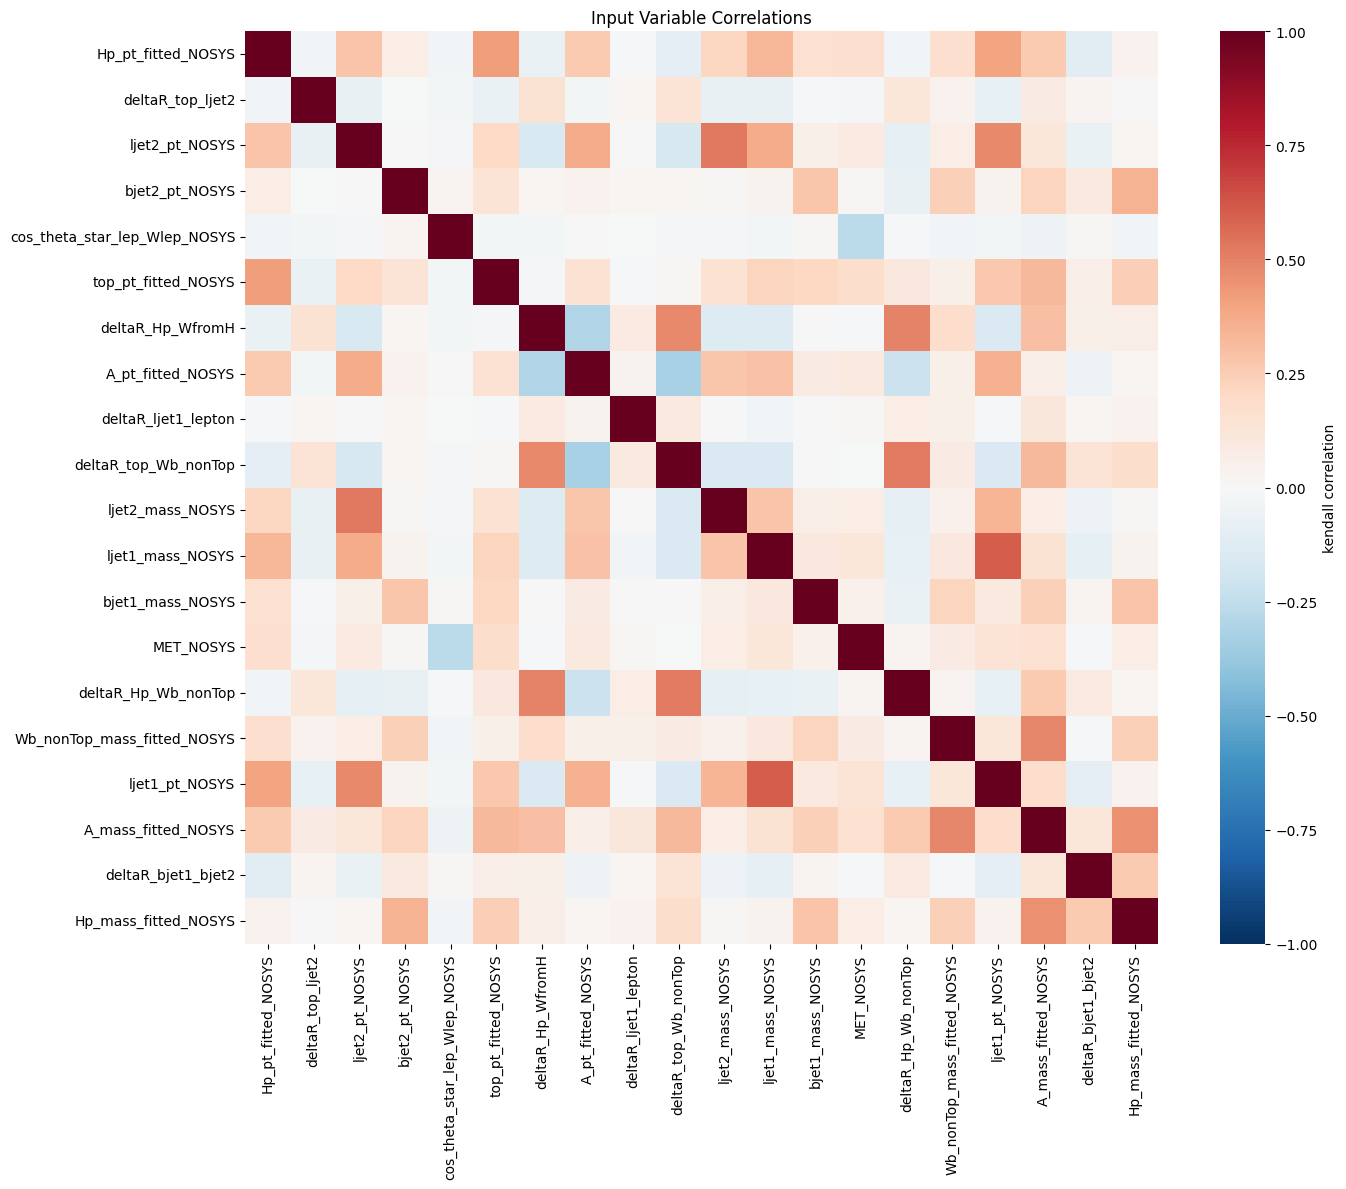


Time elapsed: 3.522962808609009 seconds


In [43]:
# Plot Correlation Coefficients
start_time = time.time()

method = 'kendall'
correlations = df[top20].astype(np.float64).corr(method = method) # Kendall correlation coefficient ...
plt.figure(figsize = (15,12))
sns.heatmap(correlations, vmin = -1, annot = False, square = True, cbar_kws = {'label' : method+' correlation'}, cmap="RdBu_r")
plt.title('Input Variable Correlations')
plt.tight_layout()
plt.savefig("xgboost_plots/xgboost_correlation_low.png", dpi=300)
plt.show()

elapsed_time = time.time() - start_time
print()
print("Time elapsed: {} seconds".format(elapsed_time))

In [45]:
correlations["ljet1_pt_NOSYS"]["ljet1_mass_NOSYS"]

0.6044887067412641

In [46]:
# Cut down the dataframes to just the top 20 variables
X_train,X_test,y_train,y_test = train_test_split(df[top20],y_df,test_size=0.2,random_state=0)

In [47]:
X_train

,Hp_pt_fitted_NOSYS,deltaR_top_ljet2,ljet2_pt_NOSYS,bjet2_pt_NOSYS,cos_theta_star_lep_Wlep_NOSYS,top_pt_fitted_NOSYS,deltaR_Hp_WfromH,A_pt_fitted_NOSYS,deltaR_ljet1_lepton,deltaR_top_Wb_nonTop,ljet2_mass_NOSYS,ljet1_mass_NOSYS,bjet1_mass_NOSYS,MET_NOSYS,deltaR_Hp_Wb_nonTop,Wb_nonTop_mass_fitted_NOSYS,ljet1_pt_NOSYS,A_mass_fitted_NOSYS,deltaR_bjet1_bjet2,Hp_mass_fitted_NOSYS
39649,361.921692,1.897629,40.292477,89.839622,-0.669913,438.323090,4.604445,57.252304,3.267159,3.666472,7.169258,21.273029,18.848972,224.405228,4.050413,1438.638428,348.633789,2324.198486,2.667760,532.094299
16163,46.809406,5.783431,30.053247,37.846634,0.780832,81.143799,4.513685,4.787832,1.977271,3.982970,0.000014,7.996171,10.297422,52.454514,4.118782,109.936852,46.974712,417.104797,2.173541,250.852325
4067,113.716766,2.325895,82.156036,29.075417,-0.251421,105.470184,3.944255,46.485054,1.503789,2.970791,12.437222,15.446035,6.664327,78.318535,3.474191,346.433502,102.506073,580.707092,1.458959,251.217361
17719,115.909859,2.121181,109.168861,27.954130,0.256314,76.744835,2.977818,112.565948,0.567366,2.804023,15.885088,15.589771,11.611819,61.322018,3.040563,301.329529,128.802689,560.985291,2.026505,298.097717
48261,13.737024,2.044608,36.174030,32.600693,-0.388274,48.640972,4.172860,3.072033,4.607037,5.058409,6.466514,4.040544,5.799749,92.888145,2.422734,140.723969,38.860962,498.390350,2.029922,360.578003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21243,69.522812,3.517255,38.567322,50.878204,-0.305774,74.038780,2.978586,32.699165,2.444279,3.051770,5.873279,12.410183,13.101658,73.978760,1.371636,249.100647,76.349136,439.464783,3.005467,303.842560
45891,36.861206,2.810016,36.975201,35.777996,0.063527,87.559059,8.224418,43.867790,4.147622,6.051746,7.032686,0.000016,7.952474,52.345604,7.065060,640.294800,38.292057,1208.948608,2.193614,245.453705
42613,262.705322,1.697104,48.190689,51.949173,0.363909,57.306568,1.106004,289.982056,4.928324,1.948671,5.691684,27.000982,39.628124,63.049789,0.518608,195.256744,251.213058,441.996155,2.906502,344.751434
43567,32.381489,1.378641,44.845581,120.284935,0.230584,150.892365,4.302212,20.230976,1.806561,3.215459,7.527575,4.620100,16.062832,85.582321,3.827604,158.401382,56.629578,494.946014,2.842792,364.248383


In [48]:
# Hyperparameter optimization
# Define the classifier
clf = xgb.XGBClassifier()

# Define the hyperparameter search space
param_space = {
    'n_estimators': (100, 1000),
    'learning_rate': (0.01, 0.03),
    'max_depth': (3, 10),
    'min_child_weight': (1, 6),
    'subsample': (0.6, 1.0),
    'colsample_bytree': (0.6, 1.0),
    'gamma': (0, 0.5),
    'reg_alpha': (0, 1),
    'reg_lambda': (0, 1),
}

# Perform Bayesian optimization
opt = BayesSearchCV(
    clf,
    param_space,
    n_iter=50,
    scoring='accuracy',
    cv=5,
    random_state=42,
    optimizer_kwargs={'base_estimator': 'GP'},
    verbose=1,
    n_jobs=-1
)

opt.fit(X_train, y_train)

# Best hyperparameters
print("Best parameters found: ", opt.best_params_)

# Best accuracy score
print("Best accuracy score: ", opt.best_score_)

# Evaluate on test set
print("Test set accuracy: ", opt.score(X_test, y_test))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [49]:
y_pred = opt.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
cm

array([[3112, 1906],
       [1303, 3561]])

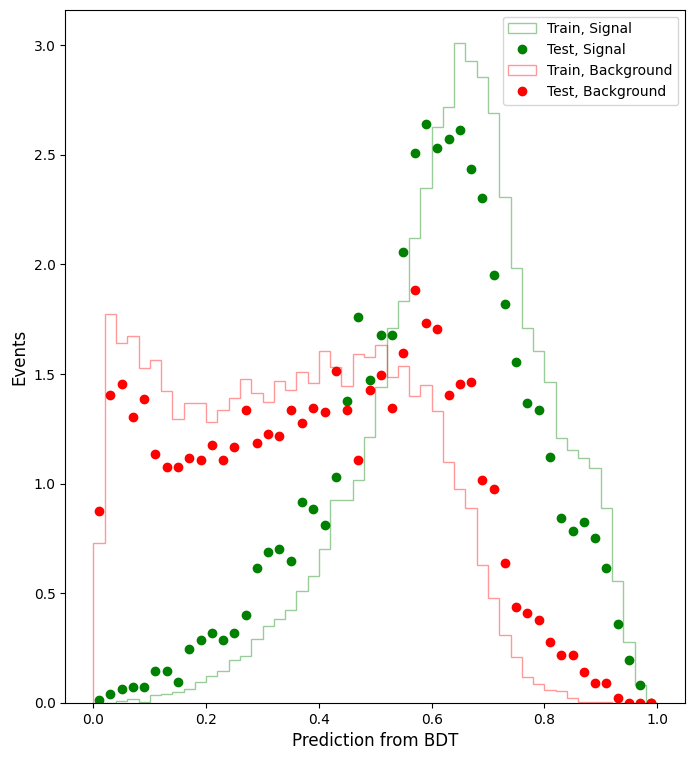

In [50]:
y_pred_phi_train = opt.predict_proba(X_train[y_train==1])
y_pred_phi_test = opt.predict_proba(X_test[y_test==1])
y_pred_tt_train = opt.predict_proba(X_train[y_train==0])
y_pred_tt_test = opt.predict_proba(X_test[y_test==0])


n_bins=50
hist_range=(0,1.0)
plt.figure(figsize=(8,9))

plt.hist(y_pred_phi_train[:,1], bins=n_bins, range=hist_range, histtype='step', color="green", density=True, alpha=0.4, label="Train, Signal")
counts, bin_edges = np.histogram(y_pred_phi_test[:,1], bins=n_bins, range=hist_range, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers, counts, marker="o", linestyle="None", color="green", label="Test, Signal")

plt.hist(y_pred_tt_train[:,1], bins=n_bins, range=hist_range, histtype='step', density=True, alpha=0.4, color="red", label="Train, Background")
counts, bin_edges = np.histogram(y_pred_tt_test[:,1], bins=n_bins, range=hist_range, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers, counts, marker="o", linestyle="None", color="red", label="Test, Background")

plt.xlabel("Prediction from BDT", fontsize=12)
plt.ylabel("Events", fontsize=12)
plt.legend()
plt.savefig("xgboost_plots/hyperparam_score_low.png", dpi=200)
plt.show()

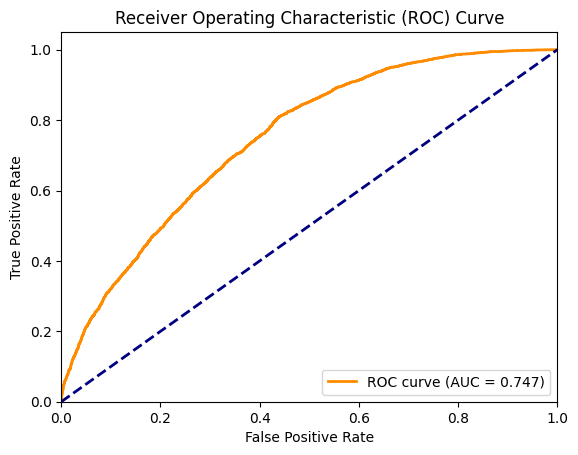

In [51]:
from sklearn.metrics import roc_curve, auc
y_prob = opt.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("xgboost_plots/hyperparam_roc_low.png", dpi=200)
plt.show()

In [52]:
# Save tpr and fpr scores into a csv file (want to plot all mass points together for comparison)
tpr = np.array(tpr)
fpr = np.array(fpr)

# File path to save the CSV file
csv_file_path = "low_xgboost_roc.csv"

# Column titles
column_titles = "tpr,fpr"

# Save the arrays into a single CSV file
np.savetxt(csv_file_path, np.column_stack((tpr.flatten(), fpr.flatten())), delimiter=',',header=column_titles)